In [1]:
import tensorflow as tf
from tensorflow import keras

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
Xf,yf = fetch_california_housing(return_X_y= True)
X_train,X_test,y_train,y_test = train_test_split(Xf,yf,test_size = .2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size = .5)

my_scaler = StandardScaler()
X_train = my_scaler.fit_transform(X_train)
X_test = my_scaler.transform(X_test)
X_val = my_scaler.transform(X_val)


In [3]:
print(X_train.shape)
print(y_train.shape)

(16512, 8)
(16512,)


## Exercise 12

Develop a Test NN to verify our Batch Normalization Layer

In [5]:
ref_model = keras.models.Sequential([
    keras.layers.Dense(30,activation='relu',input_shape = (8,)),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(1)
])

early_stop_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10,verbose = 1, restore_best_weights = True)
ref_model.compile(loss= 'mse',optimizer = keras.optimizers.SGD(learning_rate = 1e-3))
ref_hist = ref_model.fit(X_train,y_train,epochs = 100, validation_data = (X_val,y_val),callbacks = [early_stop_cb])

Epoch 1/100
516/516 [==============================] - 2s 3ms/step - loss: 1.0473 - val_loss: 0.6771
Epoch 2/100
516/516 [==============================] - 1s 2ms/step - loss: 0.5933 - val_loss: 0.5829
Epoch 3/100
516/516 [==============================] - 1s 2ms/step - loss: 0.5366 - val_loss: 0.5505
Epoch 4/100
516/516 [==============================] - 1s 2ms/step - loss: 0.5088 - val_loss: 0.5221
Epoch 5/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4906 - val_loss: 0.5049
Epoch 6/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4767 - val_loss: 0.4914
Epoch 7/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4651 - val_loss: 0.4822
Epoch 8/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4558 - val_loss: 0.4712
Epoch 9/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4481 - val_loss: 0.4623
Epoch 10/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4413 - val_lo

65/65 [==============================] - 0s 1ms/step - loss: 0.3103
0.31030380725860596


<AxesSubplot:>

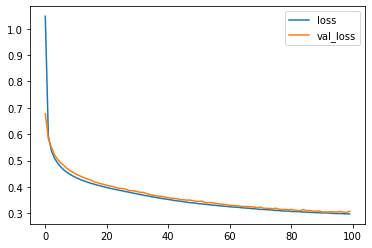

In [6]:
print(ref_model.evaluate(X_test,y_test))
pd.DataFrame(ref_hist.history).plot()

Make a Custom Layer Norm

In [7]:
class CustomLayerNorm(keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
    def build(self,X_input_shape):
        self.alpha = self.add_weight(name = 'alpha',shape = X_input_shape[-1:], dtype = float, trainable = True, initializer = 'ones')
        self.beta = self.add_weight(name = 'beta',shape = X_input_shape[-1:], dtype = float, trainable = True, initializer = 'zeros')
        super().build(X_input_shape)

        
    def call(self,X):
        self.my_mean = tf.reshape(tf.math.reduce_mean(X,axis=-1),(-1,1))
        self.my_std = tf.reshape(tf.math.reduce_std(X,axis=-1),(-1,1)) 
    
        return tf.divide(self.alpha*tf.subtract(X,self.my_mean),tf.sqrt(tf.square(self.my_std) + .001)) + self.beta

    def compute_output_shape(self,batch_input_shape):
        return batch_input_shape


In [9]:
my_model = keras.models.Sequential([
     keras.layers.Dense(30,activation='relu',input_shape = (8,)),
    CustomLayerNorm(),
    keras.layers.Dense(1)
])

early_stop_cb = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10,verbose = 1, restore_best_weights = True)
my_model.compile(loss= 'mse',optimizer = keras.optimizers.SGD(learning_rate = 1e-3))
my_hist = my_model.fit(X_train,y_train,epochs = 100, validation_data = (X_val,y_val),callbacks = [early_stop_cb])

Epoch 1/100
516/516 [==============================] - 2s 2ms/step - loss: 0.9020 - val_loss: 0.6255
Epoch 2/100
516/516 [==============================] - 1s 2ms/step - loss: 0.5513 - val_loss: 0.5550
Epoch 3/100
516/516 [==============================] - 1s 2ms/step - loss: 0.5053 - val_loss: 0.5233
Epoch 4/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4819 - val_loss: 0.4978
Epoch 5/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4670 - val_loss: 0.4830
Epoch 6/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4559 - val_loss: 0.4712
Epoch 7/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4473 - val_loss: 0.4644
Epoch 8/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4408 - val_loss: 0.4542
Epoch 9/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4356 - val_loss: 0.4490
Epoch 10/100
516/516 [==============================] - 1s 2ms/step - loss: 0.4309 - val_lo

65/65 [==============================] - 0s 1ms/step - loss: 0.3284
0.3284273147583008


<AxesSubplot:>

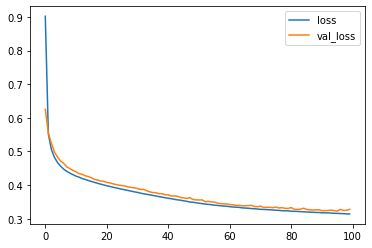

In [10]:
print(my_model.evaluate(X_test,y_test))
pd.DataFrame(my_hist.history).plot()

Verify it at the style of the Jupyter Notebook

In [11]:
default = keras.layers.LayerNormalization()
custom = CustomLayerNorm()

tf.reduce_mean(keras.losses.mean_absolute_error(custom(X_train),default(X_train)))

<tf.Tensor: shape=(), dtype=float32, numpy=6.461345e-08>

## Exercise 13A

In [1]:
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import time

import matplotlib.pyplot as plt


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full,y_train_full),(X_test,y_test) = fashion_mnist.load_data()
X_train,X_val,y_train,y_val = train_test_split(X_train_full,y_train_full,test_size=.2)

X_train,X_val,X_test = X_train/255.,X_val/255.,X_test/255.


### Aiding Functions

In [20]:
def print_info(epoch,iteration,total_iterations,mean_training_loss=[],mean_training_accuracy=[],mean_validation_loss = [],mean_validation_accuracy=[]):
    tot_width = 100
    done = (iteration * tot_width) // total_iterations
    tbd = tot_width - done
    
    print(f'epoch: {epoch+1} - Current iteration: {iteration+1}       [{"-"*(done)}{" "*(tbd)}]',end = '\r')
    
    if  mean_training_loss:
        print(f'\nMean Training Loss: {mean_training_loss :.4f}   Mean Training Accuracy: {mean_training_accuracy:.4f} || Mean Validation Loss: {mean_validation_loss:.4f}   Mean Validation Accuracy: {mean_validation_accuracy:.4f}\n')    
    

In [4]:
def batch_extraction(X,y,batch_size=32):
    samp_indx = np.random.choice(X.shape[0],batch_size)
    return X[samp_indx,:],y[samp_indx]

### Model Development

In [34]:
class my_model(keras.models.Model):
    def __init__(self,n_layers = 2, n_neurons = 1000, activation = None, **kwargs):
        super().__init__(**kwargs)        
        
        self.hiddens = [keras.layers.Dense(n_neurons,activation = activation) for _ in range(n_layers)];
        self.out = keras.layers.Dense(10,activation = 'softmax')
        
    def build(self,X_input_shape):
        self.in_layer = keras.layers.Flatten(input_shape = X_input_shape[1:])
        super().build(X_input_shape)
        
        
    def call(self,X,training = None):
        Z = self.in_layer(X)

        for layer in self.hiddens:
            Z = layer(Z)
            
        return self.out(Z)    

### Hyper Parameter Specification

In [35]:
epochs = 100
batch_size = 4096
lr = .01
momentum = .99
layers = 1
n_neurons = 100
activation = 'relu'

model = my_model(n_layers = layers, n_neurons= n_neurons, activation= activation)
optimizer = keras.optimizers.Nadam(learning_rate = lr)
#optimizer = keras.optimizers.RMSprop(learning_rate = lr, momentum = momentum)
loss_function = keras.losses.SparseCategoricalCrossentropy()

### Training Loop

In [40]:
iterations = len(X_train) //batch_size

for epoch in range(epochs):
    for iter in range(iterations):
        X_batch,y_batch = batch_extraction(X_train,y_train,batch_size = batch_size)
        
        with tf.GradientTape() as tape:
            y_pred = model(X_batch,training = True)
            loss = loss_function(y_batch,y_pred)
        
        gradients = tape.gradient(loss,model.trainable_variables) #backprop
        optimizer.apply_gradients(zip(gradients,model.trainable_variables)) #update parameters
        
        print_info(epoch,iter,iterations)
        
    ## Validation Metrics
    y_pred_train  = model(X_train,training = False)
    train_loss = loss_function(y_train,y_pred_train)
    train_accuracy = accuracy_score(y_train,np.argmax(y_pred_train,axis=1))
        
    ## Validation Metrics
    y_pred_val  = model(X_val,training = False)
    val_loss = loss_function(y_val,y_pred_val)
    val_accuracy = accuracy_score(y_val,np.argmax(y_pred_val,axis=1))
    
    print_info(epoch,iter,iterations,train_loss,train_accuracy,val_loss,val_accuracy)

epoch: 0 - Current iteration: 10       [------------------------------------------------------------------------------------------          ]
Mean Training Loss: 0.2475   Mean Training Accuracy: 0.9085 || Mean Validation Loss: 0.3268   Mean Validation Accuracy: 0.8850

epoch: 1 - Current iteration: 10       [------------------------------------------------------------------------------------------          ]
Mean Training Loss: 0.2775   Mean Training Accuracy: 0.8954 || Mean Validation Loss: 0.3526   Mean Validation Accuracy: 0.8730

epoch: 2 - Current iteration: 10       [------------------------------------------------------------------------------------------          ]
Mean Training Loss: 0.2971   Mean Training Accuracy: 0.8856 || Mean Validation Loss: 0.3750   Mean Validation Accuracy: 0.8665

epoch: 3 - Current iteration: 10       [------------------------------------------------------------------------------------------          ]
Mean Training Loss: 0.2705   Mean Training Accur

### Testing 

In [53]:
y_test_pred = model.predict(X_test)

test_accuracy = accuracy_score(y_test,np.argmax(y_test_pred,axis=1))
test_loss = loss_function(y_test,y_test_pred)

print(f'Testing accuracy: {test_accuracy}, Testing loss: {test_loss}')

Testing accuracy: 0.8734, Testing loss: 0.417889267206192


### Veriying with a pre-defined Neural Network

In [50]:
ref_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = (28,28)),
    keras.layers.Dense(100,activation = 'relu'),
    keras.layers.Dense(10,activation = 'softmax')
])

ref_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Nadam(learning_rate = .01))#, metrics = [keras.metrics.Accuracy()])
ref_model.fit(X_train,y_train, batch_size = 4096,epochs = 100, validation_data = (X_val,y_val))

Epoch 1/100
12/12 [==============================] - 2s 54ms/step - loss: 1.9462 - val_loss: 1.1900
Epoch 2/100
12/12 [==============================] - 0s 29ms/step - loss: 0.8555 - val_loss: 0.7086
Epoch 3/100
12/12 [==============================] - 0s 28ms/step - loss: 0.6904 - val_loss: 0.6475
Epoch 4/100
12/12 [==============================] - 0s 35ms/step - loss: 0.6051 - val_loss: 0.5748
Epoch 5/100
12/12 [==============================] - 0s 32ms/step - loss: 0.5809 - val_loss: 0.5751
Epoch 6/100
12/12 [==============================] - 0s 27ms/step - loss: 0.5396 - val_loss: 0.5135
Epoch 7/100
12/12 [==============================] - 0s 29ms/step - loss: 0.5396 - val_loss: 0.5562
Epoch 8/100
12/12 [==============================] - 0s 33ms/step - loss: 0.4927 - val_loss: 0.5076
Epoch 9/100
12/12 [==============================] - 0s 28ms/step - loss: 0.4767 - val_loss: 0.4671
Epoch 10/100
12/12 [==============================] - 0s 29ms/step - loss: 0.4693 - val_loss: 0.4989

In [54]:
y_test_pred = ref_model.predict(X_test)

test_accuracy = accuracy_score(y_test,np.argmax(y_test_pred,axis=1))
test_loss = loss_function(y_test,y_test_pred)

print(f'Testing accuracy: {test_accuracy}, Testing loss: {test_loss}')

Testing accuracy: 0.8715, Testing loss: 0.3653602600097656


## Exercise 13B

In [5]:
class my_model(keras.models.Model):
    def __init__(self,n_layers = 2, n_neurons = 1000, activation = None, **kwargs):
        super().__init__(**kwargs)        
        
        self.hiddens = [keras.layers.Dense(n_neurons,activation = activation, name = f'inner_{i}') for i in range(n_layers)];
        self.out = keras.layers.Dense(10,activation = 'softmax',name = 'outer')
        
    def build(self,X_input_shape):
        self.in_layer = keras.layers.Flatten(input_shape = X_input_shape[1:])
        super().build(X_input_shape)
        
        
    def call(self,X,training = None):
        Z = self.in_layer(X)

        for layer in self.hiddens:
            Z = layer(Z)
            
        return self.out(Z)    

In [40]:
epochs = 100
batch_size = 4096
lr_1 = 1e-4
lr_2 = 1e-4
momentum = .90
layers = 1
n_neurons = 100
activation = 'relu'

model = my_model(n_layers = layers, n_neurons= n_neurons, activation= activation)
loss_function = keras.losses.SparseCategoricalCrossentropy()

upper_layers_optimizer = keras.optimizers.Nadam(learning_rate = lr_1)
bottom_layers_optimizer = keras.optimizers.RMSprop(learning_rate = lr_2)


In [41]:
iterations = len(X_train) //batch_size

all_losses_training, all_losses_validation = [],[]
all_acc_training, all_acc_validation = [],[]

for epoch in range(epochs):
    for iter in range(iterations):
        X_batch,y_batch = batch_extraction(X_train,y_train,batch_size = batch_size)
        
        with tf.GradientTape(persistent = True) as tape: #persistent since we will be reading the gradients per layer
            y_pred = model(X_batch,training = True)
            loss = loss_function(y_batch,y_pred)
        
        for this_layer in model.layers:
            this_grad = tape.gradient(loss,model.get_layer(this_layer.name).trainable_variables) #get the grad
            if not this_grad: #if layer has no trainable parameters
                continue
            
            if this_layer.name.find('inner') >= 0: #this is an inner layer
                bottom_layers_optimizer.apply_gradients(zip(this_grad,model.get_layer(this_layer.name).trainable_variables))
            else: #this is an outer layer
                upper_layers_optimizer.apply_gradients(zip(this_grad,model.get_layer(this_layer.name).trainable_variables))
        
        print_info(epoch,iter,iterations)
        
    ## Validation Metrics
    y_pred_train  = model(X_train,training = False)
    train_loss = loss_function(y_train,y_pred_train)
    train_accuracy = accuracy_score(y_train,np.argmax(y_pred_train,axis=1))
        
    ## Prediction Metrics
    y_pred_val  = model(X_val,training = False)
    val_loss = loss_function(y_val,y_pred_val)
    val_accuracy = accuracy_score(y_val,np.argmax(y_pred_val,axis=1))
    
    all_losses_training.append(train_loss)
    all_losses_validation.append(val_loss)
    all_acc_training.append(train_accuracy)
    all_acc_validation.append(val_accuracy)
    
    print_info(epoch,iter,iterations,train_loss,train_accuracy,val_loss,val_accuracy)

epoch: 1 - Current iteration: 11       [------------------------------------------------------------------------------------------          ]
Mean Training Loss: 1.9636   Mean Training Accuracy: 0.3450 || Mean Validation Loss: 1.9632   Mean Validation Accuracy: 0.3396

epoch: 2 - Current iteration: 11       [------------------------------------------------------------------------------------------          ]
Mean Training Loss: 1.7241   Mean Training Accuracy: 0.4962 || Mean Validation Loss: 1.7260   Mean Validation Accuracy: 0.4952

epoch: 3 - Current iteration: 11       [------------------------------------------------------------------------------------------          ]
Mean Training Loss: 1.5316   Mean Training Accuracy: 0.6111 || Mean Validation Loss: 1.5364   Mean Validation Accuracy: 0.6041

epoch: 4 - Current iteration: 11       [------------------------------------------------------------------------------------------          ]
Mean Training Loss: 1.3752   Mean Training Accur

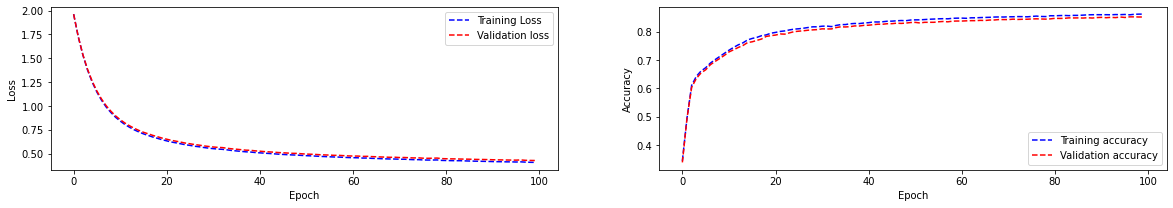

In [42]:
plt.figure(figsize = (20,3))

plt.subplot(121)
plt.plot(range(epochs),all_losses_training,'--b',label = 'Training Loss')
plt.plot(range(epochs),all_losses_validation,'--r',label = 'Validation loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(122)
plt.plot(range(epochs),all_acc_training,'--b',label = 'Training accuracy')
plt.plot(range(epochs),all_acc_validation,'--r',label = 'Validation accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()